# Imports

In [270]:
from fancyimpute import KNN

import pandas_profiling

# Common imports
import numpy as np
import numpy as np
import pandas as pd
import os

# Sklearn

from sklearn.model_selection import cross_validate, learning_curve
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression as LR

# to make this notebook's output stable across runs
np.random.seed(42)

# stats
from scipy import stats

# Vizualization
import seaborn as sns

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Preprocessing

## Data

Dataset: Breast Cancer (METABRIC, Nature 2012 & Nat Commun 2016)

Targeted sequencing of 2509 primary breast tumors with 548 matched normals

Link: http://www.cbioportal.org/study/summary?id=brca_metabric

Related article: https://www.ncbi.nlm.nih.gov/pubmed/27161491

In [2]:
df = pd.read_csv('/Users/saddler/Desktop/brca_metabric_clinical_data.tsv', sep='\t')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 35 columns):
Study ID                          2509 non-null object
Patient ID                        2509 non-null object
Sample ID                         2509 non-null object
Age at Diagnosis                  2498 non-null float64
Type of Breast Surgery            1955 non-null object
Cancer Type                       2509 non-null object
Cancer Type Detailed              2374 non-null object
Cellularity                       1917 non-null object
Chemotherapy                      1980 non-null object
Pam50 + Claudin-low subtype       1980 non-null object
Cohort                            2498 non-null float64
ER status measured by IHC         2426 non-null object
ER Status                         2469 non-null object
Neoplasm Histologic Grade         2388 non-null float64
HER2 status measured by SNP6      1980 non-null object
HER2 Status                       1980 non-null object
Tumor Othe

In [4]:
len(df['Patient ID'].unique())

2509

## Problem definition. Target Selecting

As a goal of this project I want to make Living Status prognosis of a patient (Alive/Dead), based on an patient's primary tests. As we see there are 2 variables we must look into to make such predictions - overall survival and living status.


First of all, to study them we need to drop columns, where this to parameters are not defined - either we can't work further:

In [5]:
df = df.dropna(subset=["Overall Survival (Months)", "Patient's Vital Status"])

In [6]:
df.shape

(1980, 35)

### Target selecting

As we see there are 2 variables we must look into to make such predictions - overall survival and living status.

But we must remember, that overall survival is a fixed number of month when the last analysis was made. So, for example, overall status == 160 month does not mean that the patient died after that - we do not know what happened after. So, if we want to predict living status due to parameters of the patient we need to set minimal border to predict status for. 

Let's look at the overall survival feature.

In [7]:
overall_survival_month = df['Overall Survival (Months)']

In [8]:
sns.set(style="whitegrid")

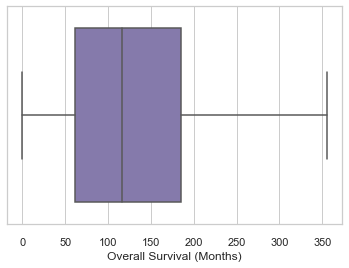

In [9]:
ax = sns.boxplot(overall_survival_month, palette=["m", "g"])

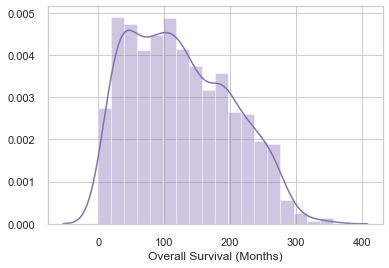

In [10]:
sns.distplot(overall_survival_month, color="m")

So how many values lying before 5 years ?

In [11]:
overall_survival_month.where(overall_survival_month < 60).count()

491

And how many of them has 'Living' status ?

In [12]:
df.where((df["Overall Survival (Months)"] < 60.) & (df["Patient's Vital Status"] == 'Living'))["Patient's Vital Status"].count()

64

So, we got 63 living patients. If we will exclude them, we will got only patients that survived more than 5 years or the ones who died before. 

To wrap up this chapter, the steps I will use to create final datasets is:
1. Find all patients with overall month survival less than chosen time criterion.
2. Exclude Living patients from them.
3. Form final dataset.

In [13]:
df = df.drop(df[(df["Overall Survival (Months)"] < 60.) & (df["Patient's Vital Status"] == 'Living')].index)

In [14]:
print(f'Patients number to calculate 5 year survival chances: {df.shape[0]}')

Patients number to calculate 5 year survival chances: 1916


### Target encoding

Now, we need to change our target to binary variable (Living/Dead) status. Let's take a look at it's values:

In [15]:
df["Patient's Vital Status"].value_counts()

Living                  773
Died of Disease         646
Died of Other Causes    497
Name: Patient's Vital Status, dtype: int64

Ok, so all we have to do is sum up 'Died' statuses and then change strings to int:

In [16]:
df["Patient's Vital Status"] = df["Patient's Vital Status"].map({
    'Died of Disease': 0,
    'Died of Other Causes': 0,
    'Living': 1
})

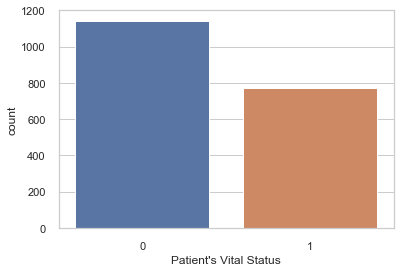

In [17]:
ax = sns.countplot(df["Patient's Vital Status"], label="Patient's Vital Status")

OK, so now we got 1916 patients, that we have data on after 5 years. 

## Preprocessing

### Basic data cleaning

First of all, let's drop obviously unnecessary columns such as:

1. **ID's:**<br>
    1.1 **Study ID** - we are not interested in this one<br>
    1.2. **Patient ID** - we do not need this too (we ensured, that this feature is unique)<br>
    1.3. **Sample ID**<br>
    
    
2. **Not relevant or doc-information columns:**<br>
    2.1.**"Oncotree" Code**<br>
    2.2. **Cancer type** - all the same after dropping 2 rows with Breast Sarcoma - outliers (we want to study only exactly breast cancer cases, also 3 raws will certainly be not enough to study different cancer type in this project)<br>
    2.3. **Sample type** - all the same<br>
    2.4. **Number of Samples Per Patient** - all the same<br>
    2.5. **Cohort** - not relevant<br>
    2.6. **Overall Survival Status** - we will use Patient Vital status instead<br>

In [18]:
df.loc[df['Cancer Type']=='Breast Sarcoma']

,Study ID,Patient ID,Sample ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,...,Overall Survival (Months),Overall Survival Status,PR Status,Radio Therapy,Number of Samples Per Patient,Sample Type,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
183,brca_metabric,MB-0281,MB-0281,52.79,MASTECTOMY,Breast Sarcoma,NaN,NaN,NO,claudin-low,...,72.8,LIVING,Negative,NO,1,Primary,NaN,NaN,0.0,1
289,brca_metabric,MB-0403,MB-0403,58.96,BREAST CONSERVING,Breast Sarcoma,NaN,High,NO,claudin-low,...,141.0,LIVING,Negative,NO,1,Primary,ER-/HER2-,NaN,1.0,1


In [19]:
df = df.drop(df.loc[df['Cancer Type']=='Breast Sarcoma'].index)

In [20]:
df = df.drop(columns=[
    'Study ID',
    'Sample ID',
    'Patient ID',
    'Oncotree Code',
    'Cancer Type',
    'Sample Type',
    'Number of Samples Per Patient',
    'Cohort',
    'Overall Survival Status',
])

As mentioned in problem definition, we want to make predictions, based only on an patient's primary tests. So, first things that we want to exclude from our datasets is future knowledges about patient treatment, not related to primary tests.

Current clinical management of the disease comprises
morphological assessment (size, grade, lymph node status), and
testing for oestrogen receptor (ER) and human epidermal growth
factor receptor 2 (HER2). 

Columns deleted:
1. **Chemotherapy** - Future
2. **Hormone Therapy** - Future
3. **Radio Therapy** - Future
4. **Type of Breast Surgery** - Future
5. **Nottingham prognostic index** - is used to determine prognosis following surgery for breast cancer - Future

In [21]:
df = df.drop(columns=['Chemotherapy', 'Hormone Therapy', 'Radio Therapy', 'Type of Breast Surgery', 'Nottingham prognostic index'])

### Missing values

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1914 entries, 0 to 1984
Data columns (total 21 columns):
Age at Diagnosis                  1914 non-null float64
Cancer Type Detailed              1875 non-null object
Cellularity                       1852 non-null object
Pam50 + Claudin-low subtype       1913 non-null object
ER status measured by IHC         1876 non-null object
ER Status                         1914 non-null object
Neoplasm Histologic Grade         1832 non-null float64
HER2 status measured by SNP6      1913 non-null object
HER2 Status                       1913 non-null object
Tumor Other Histologic Subtype    1875 non-null object
Inferred Menopausal State         1913 non-null object
Integrative Cluster               1913 non-null object
Primary Tumor Laterality          1809 non-null object
Lymph nodes examined positive     1844 non-null float64
Mutation Count                    1802 non-null float64
Overall Survival (Months)         1914 non-null float64
PR Statu

Let's use some usefull tools to checkout correlation and decide if we have some unnecessary information left

In [241]:
df.profile_report(style={'full_width':True})

There are no obviously suspicious places, so let's dig into the data

First of all, let's check how many data we will lost if we will just drop NaN columns:

In [23]:
(df.dropna().shape[0])/(df.shape[0])*100

55.43364681295716

Okay, it's obviously not an option. Than, let's start to work on it.

#### Cancer Type Detailed and Tumor Other Histologic Subtype

In [24]:
df['Cancer Type Detailed'].unique()

array(['Breast Invasive Ductal Carcinoma',
       'Breast Mixed Ductal and Lobular Carcinoma',
       'Breast Invasive Lobular Carcinoma', nan,
       'Breast Invasive Mixed Mucinous Carcinoma', 'Breast',
       'Metaplastic Breast Cancer'], dtype=object)

All of the types are obviously types of Breast cancer, so 'Breast' category is something like a NaN category (not detailed type in detailed types), so let's just assign all NaN to this category to not create one more. We will do the same for 'Tumor Other Histologic Subtype' - assign 'Other' value.

In [25]:
df.fillna({'Cancer Type Detailed': 'Breast', 'Tumor Other Histologic Subtype': 'Other'}, inplace=True)

Now, when Nan values in this columns are fixed, we can check correlation between them:

In [26]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [27]:
cramers_v(df['Cancer Type Detailed'], df['Tumor Other Histologic Subtype'])

0.9994757535681643

This two variables are basicly the same - we can drop one of them

In [28]:
df[['Cancer Type Detailed', 'Tumor Other Histologic Subtype']].head(10)

,Cancer Type Detailed,Tumor Other Histologic Subtype
0,Breast Invasive Ductal Carcinoma,Ductal/NST
1,Breast Invasive Ductal Carcinoma,Ductal/NST
2,Breast Invasive Ductal Carcinoma,Ductal/NST
3,Breast Mixed Ductal and Lobular Carcinoma,Mixed
4,Breast Mixed Ductal and Lobular Carcinoma,Mixed
5,Breast Invasive Ductal Carcinoma,Ductal/NST
6,Breast Invasive Ductal Carcinoma,Ductal/NST
7,Breast Invasive Lobular Carcinoma,Lobular
8,Breast Mixed Ductal and Lobular Carcinoma,Mixed
10,Breast Invasive Ductal Carcinoma,Ductal/NST


In [29]:
df = df.drop(columns=['Cancer Type Detailed'])

#### ER status and ER status measured by IHC

In [ ]:
unique_count = 0

for x, raw in df.iterrows():
    if not (pd.isnull(raw['ER status measured by IHC'])):
        if raw['ER status measured by IHC'] != raw['ER Status']:
            if raw['ER status measured by IHC'] == 'Positve' and raw['ER Status'] == 'Positive':
                continue
            unique_count += 1

print(x)
print(f'Percent where statuses differs: {(unique_count/x)*100}')

On 6.5 percents of patients these two features differs. There are various opportunities to choose of. We can drop one of these columns due to high correlation between them. We can fill nan values from the second column due to the first one. We can fill nan values many other ways.
I choose to drop the column due to high correlation between these two statuses.

In [ ]:
cramers_v(df['ER status measured by IHC'], df['ER Status'])

Cramers V is high, but not as in the previous example, so we will leave this features for now

In [ ]:
df['ER status measured by IHC'].unique()

In [ ]:
df['ER Status'].unique()

But we need to fill NaN Values anyway. Simpliest way with corr this high is use ER status to fill NaN values of ER status measured by IHC

In [ ]:
for idx, raw in df.iterrows():
    if (pd.isnull(raw['ER status measured by IHC'])):
        if raw['ER Status'] == 'Positive':
            df.loc[idx, 'ER status measured by IHC'] = 'Positve'
        else:
            df.loc[idx, 'ER status measured by IHC'] = raw['ER Status']

In [ ]:
df['ER status measured by IHC'].unique()

#### Tumor Stage

Tumor Stage is the column with the most values missing, so let's discuss it. As i googled it up, before 2018 Tumor stage was calculated based on just three clinical characteristics, T, N, and M:

1. the size of the cancer tumor and whether or not it has grown into nearby tissue (T) - in our data Tumor size
2. whether cancer is in the lymph nodes (N) - in our data Lymph nodes examined positive (it's even more detailed)
3. whether the cancer has spread to other parts of the body beyond the breast (M) - don't actually have this one (and it seems if it is, it's stage 4, which we have only 10 records)

Source - https://www.breastcancer.org/symptoms/diagnosis/staging 

So it's basically the column, based on other columns we already got, with a lot of missing values, that possibly will highly affect the result. In this particular case i think dropping this column will be the best choice.
Other way is to use Linear regression to generate missing values.

Let's check our hypothesis out:

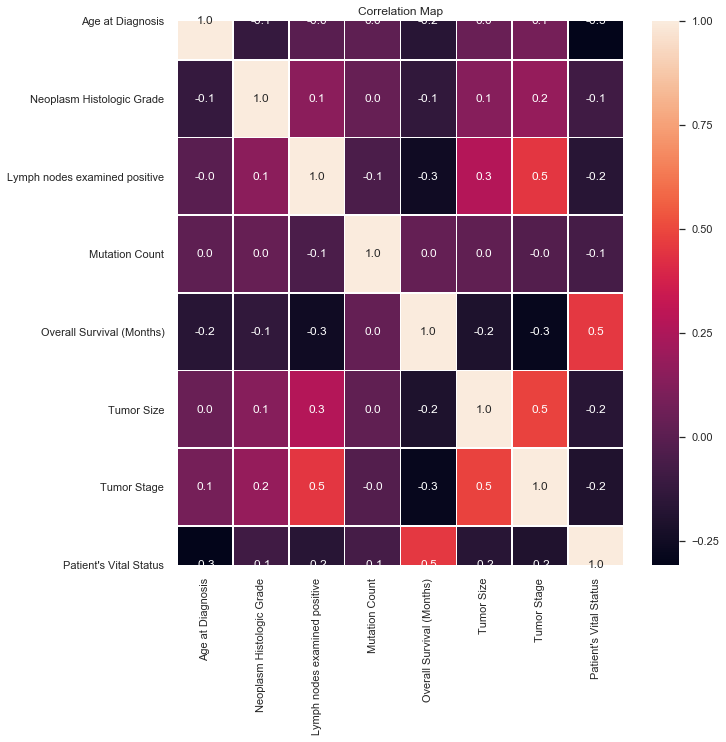

In [30]:
f,ax=plt.subplots(figsize = (10,10))
sns.heatmap(df.corr(),annot= True,linewidths=0.5,fmt = ".1f",ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Map')
plt.savefig('graph.png')
plt.show()

As we see, Tumor Stage heavily depends of 2 columns (as expected)

It's obvious, that we don't want to just drop this data. The thing we Can do to predict Tumor Stage by other values. 

In [31]:
df = df.drop(columns=['Tumor Stage'])

#### 3-Gene classifier subtype 

In [32]:
df['3-Gene classifier subtype'].unique()

array(['ER-/HER2-', 'ER+/HER2- High Prolif', nan, 'ER+/HER2- Low Prolif',
       'HER2+'], dtype=object)

Let's check if any other column can explain missing data in this one:

In [33]:
cramers_v(df['3-Gene classifier subtype'], df['ER Status'])

0.8128691764939369

In [34]:
cramers_v(df['3-Gene classifier subtype'], df['HER2 Status'])

0.8384421484813123

In [35]:
cramers_v(df['3-Gene classifier subtype'], df['Integrative Cluster'])

0.7178942668321314

In [36]:
df.loc[df['3-Gene classifier subtype'].isnull()==False][['ER Status', 'HER2 Status', '3-Gene classifier subtype']]

,ER Status,HER2 Status,3-Gene classifier subtype
0,Positive,Negative,ER-/HER2-
1,Positive,Negative,ER+/HER2- High Prolif
4,Positive,Negative,ER+/HER2- High Prolif
5,Positive,Negative,ER+/HER2- High Prolif
7,Negative,Negative,ER-/HER2-
...,...,...,...
1978,Positive,Negative,ER+/HER2- Low Prolif
1979,Positive,Negative,ER+/HER2- High Prolif
1980,Positive,Negative,ER+/HER2- Low Prolif
1983,Positive,Negative,ER+/HER2- High Prolif


In [37]:
df = df.drop(columns=['3-Gene classifier subtype'])

So now i am on the crossroad - I ca neither drop raws where 3-Gene classifier subtype is not defined or use the simplest typical method - create another category for the missing values. In this particular case 

#### Obvious outliers 

In [38]:
 for i in range(5,10):
    print(f'{df[df.isnull().sum(axis=1) > i].shape[0]} strings with {i} Nan')

2 strings with 5 Nan
1 strings with 6 Nan
1 strings with 7 Nan
0 strings with 8 Nan
0 strings with 9 Nan


In [39]:
df = df.drop(df[df.isnull().sum(axis=1) > 5].index)

In [41]:
df.shape

(1912, 18)

#### Other

In [42]:
(df.dropna().shape[0])/(df.shape[0])*100

81.64225941422593

In [43]:
df = df.dropna()

In [45]:
df.shape

(1561, 18)

### Transformation

#### Lymph nodes

In [46]:
df['Lymph nodes examined positive'].unique()

array([ 0.,  1.,  3.,  8., 24.,  4., 16.,  5., 14.,  6.,  2.,  9., 22.,
        7., 21., 13., 12., 25., 10., 41., 11., 19., 15., 17., 23., 18.,
       20., 31., 45.])

Text(0.5, 0, 'Lymph nodes examined positive')

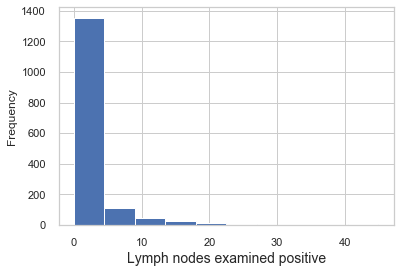

In [47]:
df['Lymph nodes examined positive'].plot.hist()
plt.xlabel('Lymph nodes examined positive', fontsize=14)

Text(0.5, 0, 'Log Lymph nodes examined positive')

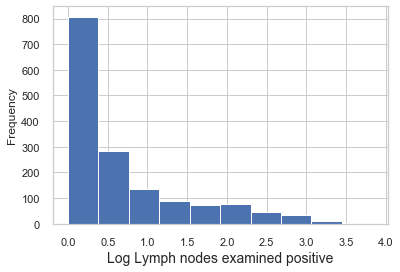

In [49]:
f = df['Lymph nodes examined positive']
f_log = f.map(lambda x: np.log(x+1))

f_log.plot.hist()
plt.xlabel('Log Lymph nodes examined positive', fontsize=14)

In [50]:
df['Lymph nodes examined positive'] = df['Lymph nodes examined positive'].apply(lambda x: np.log(x+1))

#### Mutation Count

Text(0.5, 0, 'Mutation Count')

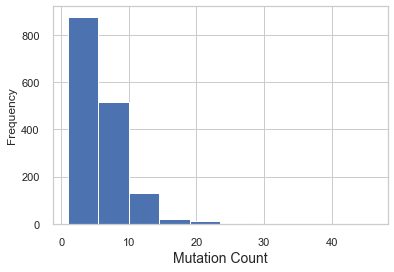

In [51]:
df['Mutation Count'].plot.hist()
plt.xlabel('Mutation Count', fontsize=14)

Text(0.5, 0, 'Log Lymph nodes examined positive')

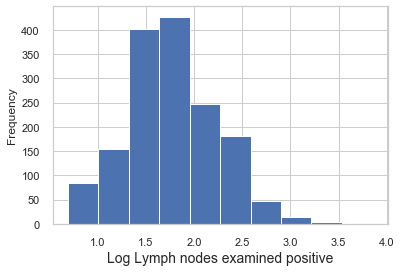

In [52]:
f = df['Mutation Count']
f_log = f.map(lambda x: np.log(x+1))

f_log.plot.hist()
plt.xlabel('Log Lymph nodes examined positive', fontsize=14)

In [53]:
df['Mutation Count'] = df['Mutation Count'].apply(lambda x: np.log(x+1))

#### Tumor Size

Text(0.5, 0, 'Tumor Size')

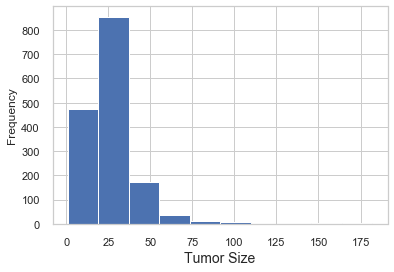

In [54]:
df['Tumor Size'].plot.hist()
plt.xlabel('Tumor Size', fontsize=14)

Text(0.5, 0, 'Tumor Size')

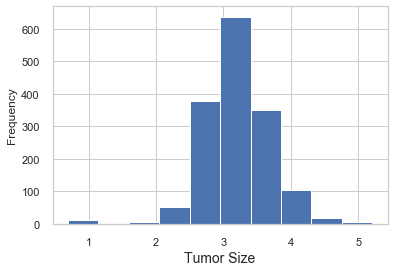

In [56]:
f = df['Tumor Size']
f_log = f.map(lambda x: np.log(x+1))

f_log.plot.hist()
plt.xlabel('Tumor Size', fontsize=14)

In [57]:
df['Tumor Size'] = df['Tumor Size'].apply(lambda x: np.log(x+1))

### Separating target

In [92]:
labels = df["Patient's Vital Status"]
data = df.drop(["Patient's Vital Status", 'Overall Survival (Months)'], axis = 1)

### Working with categorical features

In [247]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1561 entries, 1 to 1982
Data columns (total 18 columns):
df_index                          1561 non-null int64
id                                1561 non-null int64
Age at Diagnosis                  1561 non-null float64
Cellularity                       1561 non-null object
Pam50 + Claudin-low subtype       1561 non-null object
ER status measured by IHC         1561 non-null object
ER Status                         1561 non-null object
Neoplasm Histologic Grade         1561 non-null category
HER2 status measured by SNP6      1561 non-null object
HER2 Status                       1561 non-null object
Tumor Other Histologic Subtype    1561 non-null object
Inferred Menopausal State         1561 non-null object
Integrative Cluster               1561 non-null object
Primary Tumor Laterality          1561 non-null object
Lymph nodes examined positive     1561 non-null float64
Mutation Count                    1561 non-null float64
PR Status 

In [246]:
data['Neoplasm Histologic Grade'] = data['Neoplasm Histologic Grade'].astype('category')

In [62]:
numeric_cols = ['Age at Diagnosis', 'Lymph nodes examined positive','Mutation Count', 'Tumor Size']
categorical_cols = list(set(data.columns.values.tolist()) - set(numeric_cols))

In [63]:
data_cat = data[categorical_cols]
data_num = data[numeric_cols]

In [65]:
data_cat.shape

(1561, 12)

In [66]:
from sklearn.preprocessing import OneHotEncoder

In [164]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
data_cat_oh = enc.fit_transform(data_cat)

In [165]:
data_cat_oh

array([[0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 1., 1., 0.],
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 1., ..., 1., 0., 1.]])

### Splitting dataset

In [166]:
from sklearn.model_selection import train_test_split

(X_train_num, X_test_num, y_train, y_test) = train_test_split(data_num, labels, 
                                                              test_size=0.2, 
                                                              random_state=42,
                                                              stratify=labels)

(X_train_cat_oh, X_test_cat_oh) = train_test_split(data_cat_oh, 
                                                   test_size=0.2, 
                                                   random_state=42,
                                                   stratify=labels)

### Numerical features scaling

In [100]:
from sklearn.preprocessing import StandardScaler

In [167]:
scaler = StandardScaler()

X_train_num_scaled = scaler.fit_transform(X_train_num, y_train)
X_test_num_scaled = scaler.transform(X_test_num)

In [154]:
X_train_num_scaled[:5]

array([[-1.1982198 , -0.77666867,  0.34810731, -0.42302302],
       [ 0.66489644, -0.77666867,  0.34810731,  0.14172495],
       [-0.04373124, -0.77666867,  0.03843704,  0.14172495],
       [ 2.70421199,  2.53917877,  0.03843704,  0.22296229],
       [ 0.16081318,  0.07204909,  0.34810731, -0.21786463]])

### Making final train and test datasets

In [170]:
X_train_scaled = np.hstack((X_train_num_scaled, X_train_cat_oh))
X_test_scaled = np.hstack((X_test_num_scaled, X_test_cat_oh))

### Class Balancing

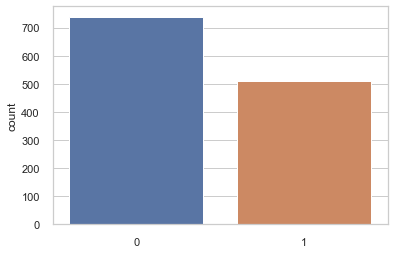

In [171]:
sns.countplot(y_train.values)

In [172]:
num_of_indices = np.sum(y_train==0) - np.sum(y_train==1)
print(np.sum(y_train==0))
print(np.sum(y_train==1))

indexes_of_first_class = np.where(y_train==1)[0]

739
509


In [173]:
indices_to_add = np.random.choice(list(indexes_of_first_class), size=num_of_indices)

X_train_to_add = X_train_scaled.take(indices_to_add, axis=0)
y_train_to_add = y_train.take(indices_to_add)

print(np.sum(y_train_to_add))

230


In [174]:
#new X, y train
X_train_balanced = np.vstack((X_train_scaled, X_train_to_add))
y_train_balanced = np.append(y_train, y_train_to_add)

print (X_train_balanced.shape, X_train_scaled.shape)
print (y_train_balanced.shape, y_train.shape)

(1478, 51) (1248, 51)
(1478,) (1248,)


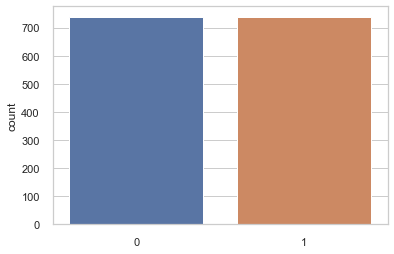

In [176]:
sns.countplot(y_train_balanced)

# Models

In [178]:
def plot_scores(optimizer):
    param_C = np.array(optimizer.cv_results_['param_C'])
    mean_cv = optimizer.cv_results_['mean_test_score']
    std_cv = optimizer.cv_results_['std_test_score']
    
    temp_1 = mean_cv - std_cv
    temp_2 = mean_cv + std_cv                                             
    
    plt.semilogx(param_C, mean_cv)
    plt.fill_between(np.array(param_C, dtype=float), np.array(temp_1, dtype=float), np.array(temp_2, dtype=float), alpha=0.3)
    plt.show()


param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3

In [179]:
estimator = LogisticRegression(solver='liblinear')

optimizer_zeros = GridSearchCV(estimator, param_grid, cv=cv)
optimizer_zeros.fit(data_train, y_train)

NameError: name 'LogisticRegression' is not defined

In [ ]:
plot_scores(optimizer_zeros)

In [206]:
rf_classifier = RandomForestClassifier(n_estimators = 500, max_depth = 10, max_features = 40, random_state = 42)

In [207]:
train_sizes, train_scores, test_scores = learning_curve(rf_classifier, X_train_balanced, y_train_balanced, 
                                                        train_sizes=np.arange(0.1,1., 0.1), 
                                                        cv=5, scoring='accuracy')

In [208]:
print (train_sizes)
print (train_scores.mean(axis = 1))
print (test_scores.mean(axis = 1))

[ 118  236  354  472  591  709  827  945 1063]
[1.         1.         0.99774011 0.99576271 0.98781726 0.98392102
 0.9738815  0.96740741 0.9625588 ]
[0.61442361 0.6469112  0.66249311 0.67535393 0.69092664 0.70247748
 0.71331127 0.71939695 0.75792885]


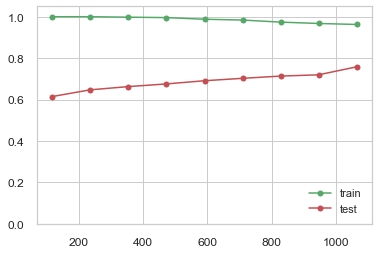

In [209]:
plt.plot(train_sizes, train_scores.mean(axis = 1), 'g-', marker='o', label='train')
plt.plot(train_sizes, test_scores.mean(axis = 1), 'r-', marker='o', label='test')
plt.ylim((0.0, 1.05))
plt.legend(loc='lower right')

Accuracy is:  0.6485623003194888


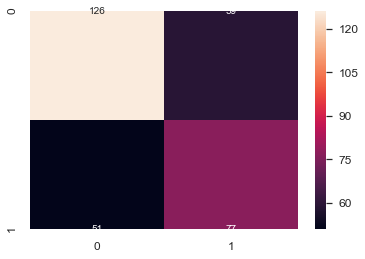

In [251]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(n_estimators = 500, max_depth = 10, max_features = 40, random_state = 42)   
clr_rf = clf_rf.fit(X_train_balanced, y_train_balanced)

ac = accuracy_score(y_test,clf_rf.predict(X_test_scaled))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_rf.predict(X_test_scaled))
sns.heatmap(cm,annot=True,fmt="d")

NameError: name 'harvest' is not defined

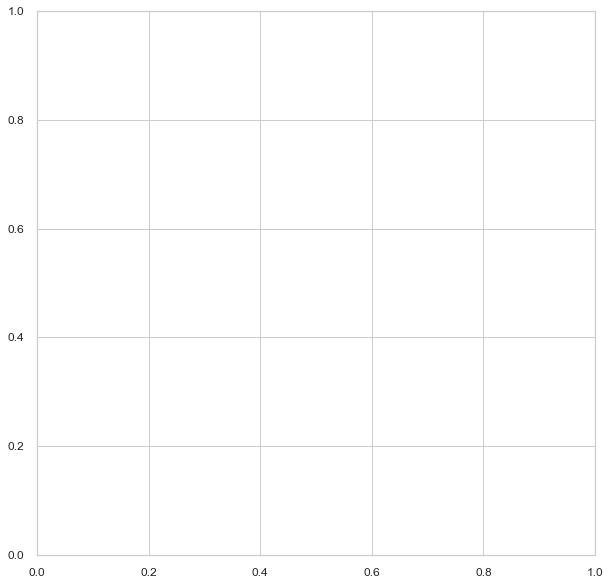

In [269]:
f, ax=plt.subplots(figsize = (10,10))
ax.set_ylim(len(harvest)-0.5, -0.5)
sns.heatmap(cm, annot=True, fmt=".1f", annot_kws={'size':16}, ax=ax)

### Feature selection

In [ ]:
models = get_models()
P = train_predict(models)
score_models(P, y_test)

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline

SEED = 42

def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=2)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=100, max_features=17, random_state=SEED)

    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              }

    return models


def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((y_test.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(data_train, y_train)
        P.iloc[:, i] = m.predict_proba(data_test)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = 1 - accuracy_score(y_test, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

Checklist:

Data types Are data types of columns matching their content? E.g. is age stored as integer and not as string?
Ranges Does the value distribution of values in a column make sense? - Yes
Emptiness Are all values non-null where mandatory? E.g. client IDs - No
Uniqueness Are duplicates present where undesired? E.g. client IDs - No